# Notas de Gonche

In [1]:
from simulator.population_networks.generic.population_network_from_hdx import PopulationNetworkFromHDX
from simulator.disasters.specific.drill_earthquake import DrillEarthQuake
from simulator.population_networks.specific.panama_costarica_zoom import PanamaCostaRicaZoom
import simulator.constants as con
import simulator.utils.general as gen_fun


import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
from datetime import datetime, timedelta


In [2]:
population_network = PanamaCostaRicaZoom()
disaster = DrillEarthQuake()

In [3]:
import numpy as np
import simulator.constants as con
import pandas as pd
from scipy.special import expit
import geopandas as gpd
from datetime import datetime, timedelta
import os

In [4]:

# Extracts Neighbors
adjacent_nodes = {}

for node_id in population_network.nodes[con.ID]:
    
    # Creates the slice
    neighbors = set([node_id])

    # Node 1
    try:
        neighbors = neighbors.union(population_network.edges.loc[pd.IndexSlice[node_id, :], con.NODE_ID2].values)
    except KeyError:
        pass

    # Node 2
    try:
        neighbors = neighbors.union(population_network.edges.loc[pd.IndexSlice[:,node_id], con.NODE_ID1].values)
    except KeyError:
        pass

    adjacent_nodes[node_id] = list(neighbors)

# Starts Simulation

# Percentage of Population with coverage
population_with_coverage = 0.3

total_elements = int(np.round(population_with_coverage*population_network.nodes[con.POPULATION].sum()))

ids = np.array([i for i in range(total_elements)])

# Creates ID
device_positions = population_network.initial_sample(ids)

device_trajectories = device_positions.rename(columns = {con.NODE_ID : con.START_NODE})

device_trajectories[con.END_NODE] = device_trajectories[con.START_NODE]

device_trajectories


   Reading nodes from Cache
   Reading edges from Cache


,id,start_node,lon,lat,end_node
0,0,Coloradito_2856,-82.907939,8.611972,Coloradito_2856
1,1,Los Planes_4898,-82.858116,8.691188,Los Planes_4898
2,2,Ojo de Agua_458,-83.277450,8.430310,Ojo de Agua_458
3,3,Alto Quiel_4897,-82.892218,8.725219,Alto Quiel_4897
4,4,Pantanal_4874,-82.846262,8.830759,Pantanal_4874
...,...,...,...,...,...
146159,146159,Divisa_3562,-82.980897,8.308883,Divisa_3562
146160,146160,Cafetal_5052,-82.717701,8.588814,Cafetal_5052
146161,146161,Salitral_4827,-82.754491,8.663976,Salitral_4827
146162,146162,Bajo Coto_1890,-83.092565,8.964488,Bajo Coto_1890


In [5]:
population_network.nodes["dist"] = population_network.nodes.apply(lambda row: (row.lon - (-82.869058))**2 + (row.lat - 8.360193)**2, axis = 1)

fun = disaster.get_function_by_date(disaster.start_date)
population_network.nodes["force"] = fun.intensity(population_network.nodes.apply(lambda row : (row[con.LON], row[con.LAT]), axis=1))

#population_network.nodes[[con.ID, "dist", "force"]].sort_values("dist").head(40)

   Generating Disaster
      Number of steps to compute: 58 hr


In [6]:
tracking_node_id = "Finca Corredor_3489"
tracking_set = set(adjacent_nodes[tracking_node_id])



tracking_set = set(population_network.nodes.sort_values("dist").head(40)[con.ID].values)

#tracking_set = set([tracking_node_id])


disaster_on = False

def extract_destination_node(df):
    '''
    Extracts the next nodes for the current node
    '''

    node_id = df[con.START_NODE].iloc[0]

    forces = population_network.nodes.loc[adjacent_nodes[node_id],[con.FINAL_FORCE]]

    if disaster_on:
        forces[con.FINAL_FORCE] = forces[con.FINAL_FORCE].apply(expit)

    # Top 3
    forces = forces.sort_values( by = con.FINAL_FORCE, ascending = False).head(min(5, forces.shape[0]))

    #if node_id in tracking_set or len(tracking_set.intersection(forces.index.values)) > 0:
    #    print(node_id)
    #    display(forces)

    forces[con.FINAL_FORCE] /= forces[con.FINAL_FORCE].sum()


    new_positions = np.random.choice(forces.index.values, df.shape[0],
              p= forces[con.FINAL_FORCE].values)

    return pd.DataFrame({con.ID : df.index, con.START_NODE : node_id, con.END_NODE : new_positions}, index = df.index)


# Updates flow and nodes
population_network.update_flow()
nodes = population_network.nodes


# Initializes movement (all devices are in nodes) 
device_trajectories = device_trajectories[[con.START_NODE]].groupby(con.START_NODE).apply(extract_destination_node).droplevel(0)

device_trajectories[con.LON] = nodes.loc[device_trajectories[con.START_NODE], con.LON].values
device_trajectories[con.LAT] = nodes.loc[device_trajectories[con.START_NODE], con.LAT].values

device_positions[con.LON] = device_trajectories[con.LON] 
device_positions[con.LAT] = device_trajectories[con.LAT] 


1 of 10
   Population in area of interest: 5924
   Min Force: 1.4392   Max Force: 2.9993
2 of 10
   Population in area of interest: 5970
   Min Force: 1.4392   Max Force: 2.9993
3 of 10
   Population in area of interest: 6097
   Min Force: 1.4392   Max Force: 2.9993
4 of 10
   Population in area of interest: 5954
   Min Force: 1.4392   Max Force: 2.9993
5 of 10
   Population in area of interest: 6039
   Min Force: 1.4392   Max Force: 2.9993


KeyboardInterrupt: 

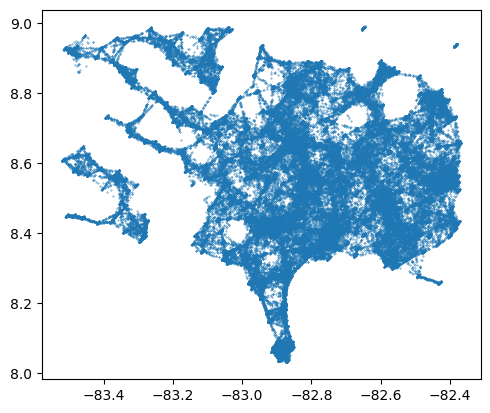

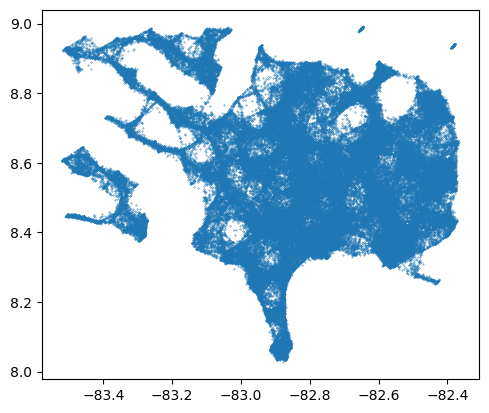

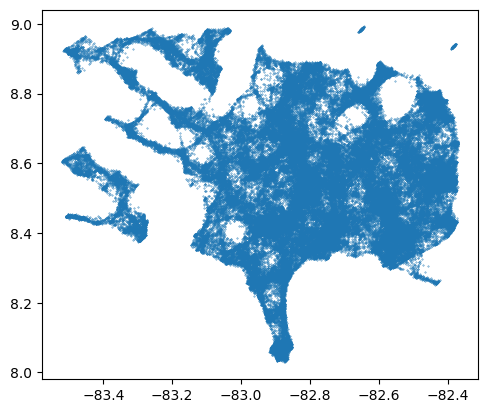

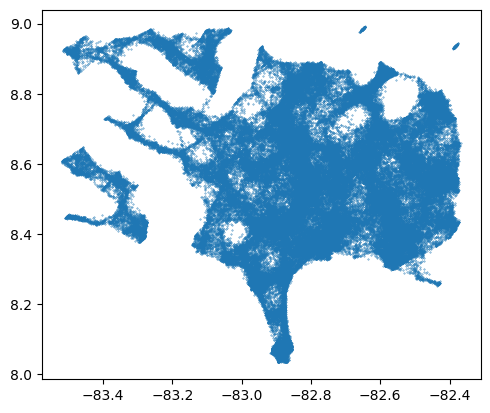

In [7]:
export_folder = "/home/minigonche/Dropbox/Projects/synthetic_mobility_data_generator/data/results/disaster_zoom"


current_date = disaster.start_date + timedelta(hours=2.5)

hours = 3
iterations = 10

disaster_on = False
for i in range(iterations):

    print(f"{i+1} of {iterations}")
    
    print(f"   Population in area of interest: { device_positions[device_positions[con.NODE_ID].isin(tracking_set)].shape[0]}")

    # Updates nodes
    fun = disaster.get_function_by_date(current_date)

    if fun is None:
        population_network.update_flow()
        print("   Disaster has not started")
    else:
        disaster_on = True
        # Extracts Forces
        force = fun.intensity(population_network.nodes.apply(lambda row : (row[con.LON], row[con.LAT]), axis=1))
        print(f"   Min Force: {np.round(np.min(force),4)}   Max Force: {np.round(np.max(force),4)}")
        population_network.update_flow(force = force)

    # Divides in two
    node_trajectories = device_trajectories[device_trajectories[con.START_NODE] == device_trajectories[con.END_NODE]]
    edge_trajectories = device_trajectories[device_trajectories[con.START_NODE] != device_trajectories[con.END_NODE]].copy()


    # Process node trajectories
    # --------------------------
    new_edge_trajectories = node_trajectories[[con.START_NODE]].groupby(con.START_NODE).apply(extract_destination_node).droplevel(0)

    # Process edge trajectories
    # --------------------------
    # Two modes
    if disaster_on:
        edge_trajectories[con.REACH_PROBABILITY] = nodes.loc[edge_trajectories[con.END_NODE], con.FINAL_FORCE].apply(expit).values
        edge_trajectories[con.REACH_PROBABILITY] /= ( edge_trajectories[con.REACH_PROBABILITY].values + nodes.loc[edge_trajectories[con.START_NODE], con.FINAL_FORCE].apply(expit)).values
    else:
        edge_trajectories[con.REACH_PROBABILITY] = nodes.loc[edge_trajectories[con.END_NODE], con.FINAL_FORCE].values
        edge_trajectories[con.REACH_PROBABILITY] /= edge_trajectories[con.REACH_PROBABILITY].values + nodes.loc[edge_trajectories[con.START_NODE], con.FINAL_FORCE].values

    random_vector = np.random.random(edge_trajectories.shape[0])

    # Devices that reach
    edge_trajectories.loc[random_vector <= edge_trajectories[con.REACH_PROBABILITY], con.START_NODE] = edge_trajectories[con.END_NODE]

    # Devices that don't
    edge_trajectories.loc[random_vector > edge_trajectories[con.REACH_PROBABILITY], con.END_NODE] = edge_trajectories[con.START_NODE]


    # Consolidates
    new_node_trajectories = edge_trajectories[[con.ID, con.START_NODE, con.END_NODE]]

    # Creates new frame
    new_device_trajectories = pd.concat((new_edge_trajectories, new_node_trajectories))

    new_device_positions = population_network.sample(device_positions, new_device_trajectories.loc[device_positions[con.ID], con.END_NODE].values)
    
    # Sets Date
    date_string = current_date.strftime("%m-%d-%Y_%H:%M:%S")
    new_device_positions[con.DATE] = date_string

    filename = f"{os.path.join(export_folder,date_string)}.csv"
    new_device_positions[[con.ID, con.DATE, con.LON, con.LAT]].to_csv(filename, index = False)

    # Advances
    device_positions = new_device_positions
    device_trajectories = new_device_trajectories

    current_date += timedelta(hours = hours)

    #display(new_device_trajectories[(new_device_trajectories.start_node == tracking_node_id) |(new_device_trajectories.end_node == tracking_node_id) ])



    gpd.GeoDataFrame(device_positions, geometry = device_positions.apply(lambda row : Point(row.lon, row.lat) , axis = 1), crs = con.USUAL_PROJECTION).plot(markersize = 0.1)


In [8]:
population_network.nodes[population_network.nodes[con.ID].isin(tracking_set)]

,id,lat,lon,population,geometry,dist,force,repelling_force,attractive_force,final_force
id,,,,,,,,,,
Asentamiento Almendro_962,Asentamiento Almendro_962,8.428443,-82.875881,420.0,"POLYGON ((-82.86241 8.42844, -82.87588 8.41511...",0.004705,2.985919,2.985919,0.230389,-2.755530
Finca Higuito_3488,Finca Higuito_3488,8.348996,-82.885727,500.0,"POLYGON ((-82.87225 8.34900, -82.88573 8.33566...",0.000403,2.998791,2.998791,0.274273,-2.724517
Finca Corredor_3489,Finca Corredor_3489,8.345356,-82.874371,500.0,"POLYGON ((-82.86090 8.34536, -82.87437 8.33202...",0.000248,2.999255,2.999255,0.274273,-2.724982
Finca Blanco_3490,Finca Blanco_3490,8.382777,-82.871611,500.0,"POLYGON ((-82.85814 8.38278, -82.87161 8.36945...",0.000517,2.998451,2.998451,0.274273,-2.724178
San Antonio_3491,San Antonio_3491,8.371938,-82.885808,500.0,"POLYGON ((-82.87233 8.37194, -82.88581 8.35861...",0.000419,2.998745,2.998745,0.274273,-2.724472
Finca Bongo_3492,Finca Bongo_3492,8.406808,-82.904314,500.0,"POLYGON ((-82.89084 8.40681, -82.90431 8.39348...",0.003416,2.989770,2.989770,0.274273,-2.715497
Berba_3507,Berba_3507,8.383347,-82.813317,500.0,"POLYGON ((-82.79984 8.38335, -82.81332 8.37002...",0.003643,2.989090,2.989090,0.274273,-2.714817
Finca Palmito #1_3516,Finca Palmito #1_3516,8.413590,-82.875488,500.0,"POLYGON ((-82.86201 8.41359, -82.87549 8.40026...",0.002893,2.991335,2.991335,0.274273,-2.717062
Finca Palmito Viejo_3517,Finca Palmito Viejo_3517,8.405173,-82.863094,500.0,"POLYGON ((-82.84962 8.40517, -82.86309 8.39184...",0.002059,2.993830,2.993830,0.274273,-2.719557


<Axes: >

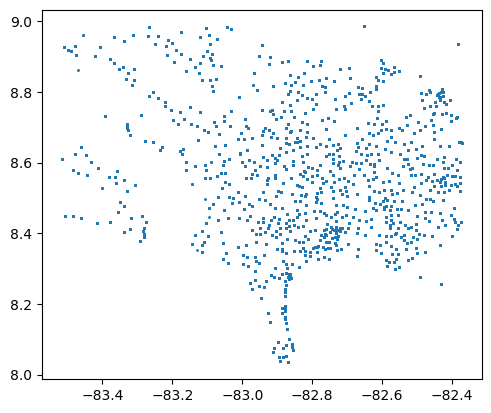

In [8]:
device_positions = population_network.initial_sample(ids)
gpd.GeoDataFrame(device_positions, geometry = device_positions.apply(lambda row : Point(row.lon, row.lat) , axis = 1), crs = con.USUAL_PROJECTION).plot(markersize = 0.1)


In [9]:
gpd.GeoDataFrame(device_positions, geometry = device_positions.apply(lambda row : Point(row.lon, row.lat) , axis = 1), crs = con.USUAL_PROJECTION).to_file("temp")

In [15]:
import math

latitude = 9  # Latitude of Panama

# Calculate the distance covered by 1 degree of latitude and longitude at the given latitude
lat_distance = 111  # Approximate distance covered by 1 degree of latitude (in km)
lon_distance = 111 * math.cos(math.radians(latitude))  # Approximate distance covered by 1 degree of longitude (in km)

print(f"1 km in Panama is approximately {1/lat_distance} degrees of latitude and {1/lon_distance} degrees of longitude.")


1 km in Panama is approximately 0.009009009009009009 degrees of latitude and 0.009121307439531557 degrees of longitude.


In [4]:
# Reads edges
edges = population_network.edges 

   Reading edges from Cache


In [43]:
import pandas as pd
import numpy as np
import geopandas as gpd

from shapely.geometry import Point, LineString

In [9]:
edges[con.ROAD_LENGTH] = edges[con.GEOMETRY].to_crs(con.MANIPULATION_PROJECTION).length/1000
edges[con.POPULATION] = edges[con.ROAD_LENGTH].apply(lambda l : min(1,int(np.round(l*con.ROAD_SAMPLE_DENSITY_BY_KM))))


In [26]:
# Gets the coordinates
edge_sample_constructor = edges[[con.GEOMETRY]].copy()
coords = edge_sample_constructor[con.GEOMETRY].apply(lambda geo : geo.coords).values


edge_sample_constructor[con.LON_X] = [coor[0][0] for coor in coords]
edge_sample_constructor[con.LAT_X] = [coor[0][1] for coor in coords]
edge_sample_constructor[con.LON_Y] = [coor[1][0] for coor in coords]
edge_sample_constructor[con.LAT_Y] = [coor[1][1] for coor in coords]

edge_sample_constructor = edge_sample_constructor[[con.LON_X, con.LAT_X, con.LON_Y, con.LAT_Y]].copy()


<Axes: >

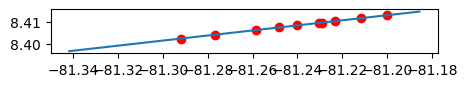

In [52]:
edge_id = edge_sample_constructor.index.values[np.random.randint(edge_sample_constructor.shape[0])]
num_points = 10

t = edge_sample_constructor.loc[[edge_id]*num_points]
vals = np.random.rand(sample_size)
t[con.LON] = t[con.LON_X]*vals + t[con.LON_Y]*(1-vals)
t[con.LAT] = t[con.LAT_X]*vals + t[con.LAT_Y]*(1-vals)

response = t[[con.LON, con.LAT]]

response = gpd.GeoDataFrame( response, geometry = response.apply(lambda row : Point(row.lon, row.lat) , axis = 1), crs = con.USUAL_PROJECTION)


ax = edges.loc[[edge_id]].plot(figsize=(5,5))
response.plot(ax = ax, color = "red")



In [7]:

# Iterates over the edges o construct sample points
print_iteration_progress = True
percentage_print = 0.1
batch = int(np.ceil(edges.shape[0]*percentage_print))


index_names = list(edges.index.names)

dfs = []
for ind, row in edges.iterrows():

    if print_iteration_progress and len(dfs) % batch == 0:
        print(f"         Progress: {np.round(100*len(dfs)/edges.shape[0])}%")

    coords = np.array(row.geometry.coords)

    sample_size = row[con.POPULATION]

    vals = np.random.rand(sample_size)

    lon = coords[0,0]*vals + coords[1,0]*(1-vals)
    lat = coords[0,1]*vals + coords[1,1]*(1-vals)

    df = pd.DataFrame({con.LON : lon, con.LAT: lat})

    df.index = pd.MultiIndex.from_tuples([ind]*sample_size, names=index_names)

    dfs.append(df)
    

sample_points = pd.concat(dfs)
sample_points



         Progress: 0.0%
         Progress: 10.0%


KeyboardInterrupt: 

In [5]:
from os.path import join
import simulator.constants as con
import simulator.utils.geometric as geo_fun
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np

world_pop_density_file = join(con.DATA_FOLDER,"costa_rica-panama/pd_2020_1km_ASCII_XYZ.csv")
populated_places_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_populated_places_points_shp")
road_lines_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_roads_lines_shp")
building_polygons_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_buildings_polygons_shp")

,geometry,highway
0,"MULTILINESTRING ((-84.14531 9.95885, -84.14520...",service
1,"MULTILINESTRING ((-84.09124 9.94787, -84.09146...",secondary
2,"MULTILINESTRING ((-84.11712 9.94019, -84.11713...",trunk_link
3,"MULTILINESTRING ((-84.11646 9.93860, -84.11651...",trunk_link
4,"LINESTRING (-84.11648 9.93629, -84.11643 9.936...",trunk_link
...,...,...
57388,"MULTILINESTRING ((-82.84401 8.69199, -82.84450...",bridleway
57389,"MULTILINESTRING ((-82.82806 8.87898, -82.82830...",unclassified
57390,"MULTILINESTRING ((-82.90799 8.44169, -82.90794...",footway
57391,"LINESTRING (-82.90817 8.44242, -82.90773 8.44224)",footway


         Progress: 0.0%
         Progress: 10.0%
         Progress: 20.0%
         Progress: 30.0%
         Progress: 40.0%
         Progress: 50.0%
         Progress: 60.0%
         Progress: 70.0%
         Progress: 80.0%
         Progress: 90.0%


,lon,lat
0,-84.143179,9.958370
0,-84.141287,9.958160
0,-84.143858,9.958684
0,-84.142863,9.959875
0,-84.144137,9.960139
...,...,...
57392,-84.144025,9.957689
57392,-84.143565,9.958053
57392,-84.143013,9.960531
57392,-84.142431,9.958819


In [48]:
# Assigns to the edges
bounds = edges[con.GEOMETRY].bounds


margin = con.ROADS_WIDTH_KM/DEGREE_EQUIVALENT_IN_KM

batch = int(np.ceil(bounds.shape[0]*percentage_print))

dfs = []
# Iterates over the bounds
for ind, row in bounds.iterrows():

    if print_iteration_progress and len(dfs) % batch == 0:
        print(f"         Progress: {np.round(100*len(dfs)/roads.shape[0])}%")

    # Filters
    points = sample_points_by_road[(sample_points_by_road[con.LON] <= (row.maxx + margin)) &
                                   (sample_points_by_road[con.LON] >= (row.minx - margin)) &
                                   (sample_points_by_road[con.LAT] <= (row.maxy + margin)) &
                                   (sample_points_by_road[con.LAT] >= (row.miny - margin))]
    #
    #points.index = ind

    dfs.append(points)


         Progress: 0.0%
         Progress: 211.0%


: 

: 

In [4]:
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
import geopandas as gpd

,lon,lat
Liberia_0,-85.480060,10.565376
Liberia_0,-85.483245,10.567046
Liberia_0,-85.485343,10.567941
Liberia_0,-85.485268,10.568108
Liberia_0,-85.485731,10.568351
...,...,...
Refugio Migrantes El Abuelo_6442,-77.744189,8.648758
Refugio Migrantes El Abuelo_6442,-77.745199,8.647782
Refugio Migrantes El Abuelo_6442,-77.745269,8.647852
Refugio Migrantes El Abuelo_6442,-77.745345,8.647789


In [7]:
nodes = nodes.sample(100)

In [8]:
search_unit = 0.0018 # 200m in the equator

exploded_geometries = nodes.explode(index_parts=False)
exploded_geometries = exploded_geometries[[con.GEOMETRY]].copy()

dfs = []
for ind, row in exploded_geometries.iterrows():
    boundary = list(row.geometry.exterior.coords)
    dfs.append(pd.DataFrame({con.LON : [t[0] for t in boundary], con.LAT : [t[1] for t in boundary]}, index = [ind for _ in boundary]))

boundary_points = pd.concat(dfs)
boundary_points


# Sample point structure
sample_points = pd.DataFrame(columns=[con.ID, con.LON, con.LAT])


# Progress
progress = pd.DataFrame(columns=[con.ID, "count"])
progress = progress.merge(nodes[[con.ID, con.POPULATION]].reset_index(drop = True), how = "right").fillna(0)
progress["per"] = progress["count"] / progress[con.POPULATION]

# Filters
progress = progress[progress.per < 1]

sample_size = 100

print("Started Sampling")
while progress.shape[0] > 0:

    current_progress = np.round(100*(nodes.shape[0] - progress.shape[0])/nodes.shape[0],2)
    print(f"   Min Coverage: {np.round(100*progress.per.min(), 2)}%")
    print(f"   Constructing Samples for {progress.shape[0]} elements of {nodes.shape[0]} ({current_progress}%)")
    dfs = []
    batch = int(np.ceil(progress.shape[0]*0.25))

    sample_size = int(np.round(sample_size*1.1))

    print(f"   Sample Size: {sample_size}")
        
    for id, row in progress.iterrows():

        if len(dfs) % batch == 0:
            print(f"      Progress: {np.round(100*len(dfs)/progress.shape[0])}%")

        
        # Extracts valid points
        local_sample_points = boundary_points.loc[row[con.ID]]
        if row[con.ID] in sample_points.index:
            local_sample_points = pd.concat((local_sample_points, sample_points.loc[row[con.ID],[con.LON, con.LAT]]))

        
        local_sample_points = local_sample_points.sample(sample_size, replace = True)

        # Adds Noise
        local_sample_points[con.LON] += np.random.uniform(-1*search_unit, search_unit, local_sample_points.shape[0])
        local_sample_points[con.LON] = np.round(local_sample_points[con.LON],5)

        local_sample_points[con.LAT] += np.random.uniform(-1*search_unit, search_unit, local_sample_points.shape[0])
        local_sample_points[con.LAT] = np.round(local_sample_points[con.LAT],5)
        
        local_sample_points[con.GEOMETRY] = local_sample_points.apply(lambda row: Point(row[con.LON], row[con.LAT]), axis = 1)

        dfs.append(local_sample_points)


    print("      Done")

    possible_sample_points = pd.concat(dfs, ignore_index=True)
    possible_sample_points = gpd.GeoDataFrame(possible_sample_points, geometry= con.GEOMETRY, crs = con.USUAL_PROJECTION)


    print("   Filtering")
    inter = nodes[[con.ID, con.GEOMETRY]].sjoin(possible_sample_points[[con.GEOMETRY]])

    final_sample_points = inter[[con.ID, "index_right"]].merge(possible_sample_points, left_on = "index_right", right_index = True)
    final_sample_points = final_sample_points[[con.ID, con.LON, con.LAT]]

    # Joins
    sample_points = pd.concat((sample_points, final_sample_points))

    # Checks threshold
    progress = pd.DataFrame(sample_points[con.ID].value_counts()).reset_index()
    progress = progress.merge(nodes[[con.ID, con.POPULATION]].reset_index(drop = True), how = "right").fillna(0)
    progress["per"] = progress["count"] / progress[con.POPULATION]

    # Cleans
    sample_points = sample_points.reset_index(drop = True)
    under = sample_points.merge(progress.loc[progress.per <= 1,[con.ID]])

    over = sample_points.merge(progress.loc[progress.per > 1,[con.ID]])
    over = over.groupby(con.ID).apply(lambda df : df.sample(int(np.round(nodes.loc[df[con.ID].iloc[0], con.POPULATION])),replace=True))
    
    sample_points = pd.concat((under, over), ignore_index = True)
    sample_points.index = sample_points[con.ID]

    # Sets Progress
    progress = progress[progress.per < 1]


    print(f"Current Samples: {sample_points.shape[0]}")
    print("---------------")
    print("")


print("Finished Sampling")
print(f"Total Samples: {sample_points.shape[0]}")



Started Sampling
   Min Coverage: 0.0%
   Constructing Samples for 100 elements of 100 (0.0%)
   Sample Size: 110
      Progress: 0.0%
      Progress: 25.0%
      Progress: 50.0%
      Progress: 75.0%
      Done
   Filtering
Current Samples: 3538
---------------

   Min Coverage: 0.1%
   Constructing Samples for 98 elements of 100 (2.0%)
   Sample Size: 121
      Progress: 0.0%
      Progress: 26.0%
      Progress: 51.0%
      Progress: 77.0%
      Done
   Filtering
Current Samples: 9605
---------------

   Min Coverage: 0.21%
   Constructing Samples for 92 elements of 100 (8.0%)
   Sample Size: 133
      Progress: 0.0%
      Progress: 25.0%
      Progress: 50.0%
      Progress: 75.0%
      Done
   Filtering
Current Samples: 16793
---------------

   Min Coverage: 0.37%
   Constructing Samples for 77 elements of 100 (23.0%)
   Sample Size: 146
      Progress: 0.0%
      Progress: 26.0%
      Progress: 52.0%
      Progress: 78.0%
      Done
   Filtering
Current Samples: 23899
----------

<Axes: >

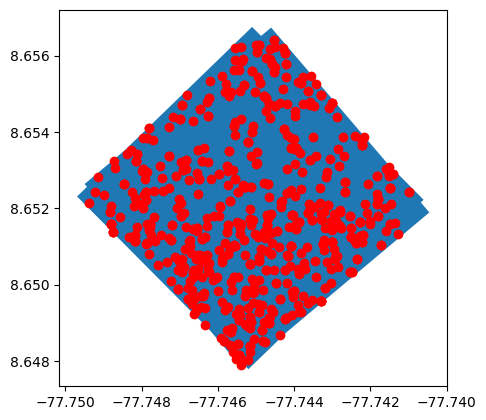

In [28]:
node = nodes.sample(1)

ax = node.plot(figsize=(5,5))

points = sample_points.loc[node[con.ID].iloc[0]].copy()
points[con.GEOMETRY] = points.apply(lambda row: Point(row[con.LON], row[con.LAT]), axis = 1)
points = gpd.GeoDataFrame(points, geometry = con.GEOMETRY)

points.plot(ax = ax, color = "red")


<Axes: >

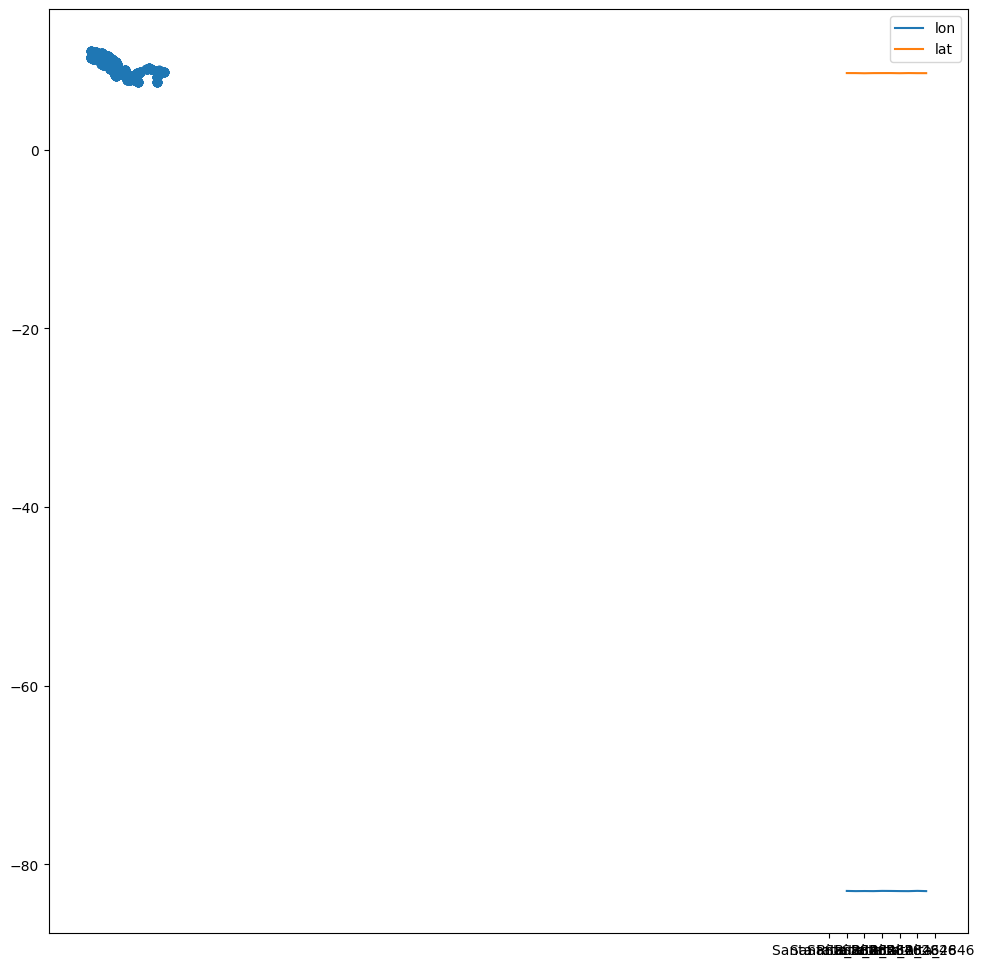

In [20]:
ax = local_sample_points.plot(figsize=(12,12))
possible_sample_points.plot(ax = ax)

In [ ]:
edge_id = population_network.edges.index.values[np.random.randint(population_network.edges.shape[0])]
num_points = 10

response = population_network.sample_from_edge(edge_id, num_points)
response = gpd.GeoDataFrame( response, geometry = response.apply(lambda row : Point(row.lon, row.lat) , axis = 1), crs = con.USUAL_PROJECTION)


ax = population_network.edges.loc[[edge_id]].plot(figsize=(5,5))
response.plot(ax = ax, color = "red")


In [ ]:
# Enhances
if current_progress <= 60:
    print("   Enhancing")
    valid_points = sample_points.merge(progress.loc[progress.per < 1, [con.ID]])
    valid_points = valid_points.drop(con.ID, axis=1)

    dfs = []
    num_iters = 10
    for i in range(num_iters):
        temp = valid_points.copy()
        temp[con.LON] += np.random.uniform(-1*search_unit, search_unit, temp.shape[0])
        temp[con.LAT] += np.random.uniform(-1*search_unit, search_unit, temp.shape[0])
        temp[con.GEOMETRY] = temp.apply(lambda row: Point(row[con.LON], row[con.LAT]), axis = 1)

        print(f"      Iteration {i+1} of {num_iters}")
        dfs.append(temp)


    possible_sample_points = pd.concat(dfs, ignore_index=True)
    possible_sample_points = gpd.GeoDataFrame(possible_sample_points, geometry= con.GEOMETRY, crs = con.USUAL_PROJECTION)

    inter = nodes[[con.ID, con.GEOMETRY]].sjoin(possible_sample_points[[con.GEOMETRY]])

    final_sample_points = inter[[con.ID, "index_right"]].merge(possible_sample_points, left_on = "index_right", right_index = True)
    final_sample_points = final_sample_points[[con.ID, con.LON, con.LAT]].reset_index(drop = True)

    # Joins
    sample_points = pd.concat((sample_points, final_sample_points), ignore_index=True)

    # Checks threshold
    progress = pd.DataFrame(sample_points[con.ID].value_counts()).reset_index()
    progress = progress.merge(nodes[[con.ID, con.POPULATION]].reset_index(drop = True), how = "right").fillna(0)
    progress["per"] = progress["count"] / progress[con.POPULATION]

,id,lon,lat
0,Liberia_0,-85.48113,10.56958
1,Liberia_0,-85.45541,10.57188
2,Liberia_0,-85.43387,10.62437
3,Liberia_0,-85.42401,10.59706
4,Liberia_0,-85.42418,10.59716
...,...,...,...
953381,La Unión_6056,-80.00231,9.32291
953382,Nuevo Porvenir_6061,-80.03780,9.10351
953383,Los Higuerones_6163,-82.30952,9.13878
953384,Isla Popa #2_6175,-82.15900,9.24060


In [ ]:
# Sample point structure
sample_points = pd.DataFrame(columns=[con.ID, con.LON, con.LAT])


# Progress
progress = pd.DataFrame(columns=[con.ID, "count"])
progress = progress.merge(nodes[[con.ID, con.POPULATION]].reset_index(drop = True), how = "right").fillna(0)
progress["per"] = progress["count"] / progress[con.POPULATION]

# Filters
progress = progress[progress.per < 1]

# Explodes
exploded_geometries = nodes.explode(index_parts=False)
bounds = exploded_geometries[con.GEOMETRY].bounds
bounds[con.GEOMETRY] = exploded_geometries[con.GEOMETRY]


print("Started Sampling")
while progress.shape[0] > 0:

    selected_bounds = bounds.loc[bounds.index.isin(progress[con.ID])]

    current_progress = np.round(100*progress.shape[0]/nodes.shape[0],2)
    print(f"   Min Coverage: {np.round(100*progress.per.min(), 2)}")
    print(f"   Constructing Samples for {progress.shape[0]} elements of {nodes.shape[0]} ({current_progress}%)")
    dfs = []
    batch = int(np.floor(selected_bounds.shape[0]*0.01))
        
    for id, row in selected_bounds.iterrows():

        if len(dfs) % batch == 0:
            print(f"      Progress: {np.round(100*len(dfs)/selected_bounds.shape[0])}%")

        #Random
        sample_size = 10
        local_sample_points = pd.DataFrame({con.LON : np.round(np.random.uniform(row.minx, row.maxx, sample_size),5), con.LAT : np.round(np.random.uniform(row.miny, row.maxy, sample_size), 5)})
        local_sample_points[con.GEOMETRY] = local_sample_points.apply(lambda row: Point(row[con.LON], row[con.LAT]), axis = 1)

        # From Boundary
        boundary = list(row.geometry.exterior.coords)
        boundary_sample_points = pd.DataFrame({con.LON : [t[0] for t in boundary], con.LAT : [t[0] for t in boundary]})
        boundary_sample_points = boundary_sample_points.sample(sample_size, replace = True)

        # Adds Noise
        boundary_sample_points[con.LON] += np.random.uniform(-1*search_unit, search_unit, boundary_sample_points.shape[0])
        boundary_sample_points[con.LON] = np.round(boundary_sample_points[con.LON],5)

        boundary_sample_points[con.LAT] += np.random.uniform(-1*search_unit, search_unit, boundary_sample_points.shape[0])
        boundary_sample_points[con.LAT] = np.round(boundary_sample_points[con.LAT],5)
        
        boundary_sample_points[con.GEOMETRY] = boundary_sample_points.apply(lambda row: Point(row[con.LON], row[con.LAT]), axis = 1)

        final_points = pd.concat((local_sample_points,), ignore_index = True)

        dfs.append(final_points)

    print("      Done")

    possible_sample_points = pd.concat(dfs, ignore_index=True)
    possible_sample_points = gpd.GeoDataFrame(possible_sample_points, geometry= con.GEOMETRY, crs = con.USUAL_PROJECTION)


    print("   Filtering")
    inter = nodes[[con.ID, con.GEOMETRY]].sjoin(possible_sample_points[[con.GEOMETRY]])

    final_sample_points = inter[[con.ID, "index_right"]].merge(possible_sample_points, left_on = "index_right", right_index = True)
    final_sample_points = final_sample_points[[con.ID, con.LON, con.LAT]].reset_index(drop = True)

    # Joins
    sample_points = pd.concat((sample_points, final_sample_points), ignore_index=True)

    # Checks threshold
    progress = pd.DataFrame(sample_points[con.ID].value_counts()).reset_index()
    progress = progress.merge(nodes[[con.ID, con.POPULATION]].reset_index(drop = True), how = "right").fillna(0)
    progress["per"] = progress["count"] / progress[con.POPULATION]

    # Cleans
    under = sample_points.merge(progress.loc[progress.per <= 1,[con.ID]])

    over = sample_points.merge(progress.loc[progress.per > 1,[con.ID]])
    over = over.groupby(con.ID).apply(lambda df : df.sample(int(np.round(nodes.loc[df[con.ID].iloc[0], con.POPULATION])),replace=True)).reset_index(drop = True)

    sample_points = pd.concat((under, over), ignore_index=True)

    # Sets Progress
    progress = progress[progress.per < 1]


    print(f"Current Samples: {sample_points.shape[0]}")
    print("---------------")
    print("")


print("Finished Sampling")
print(f"Total Samples: {sample_points.shape[0]}")



,id,lat,lon,population,geometry
id,,,,,
Liberia_0,Liberia_0,10.633340,-85.436272,58726.0,"MULTIPOLYGON (((-85.48115 10.56952, -85.48119 ..."
Tilarán_1,Tilarán_1,10.470980,-84.967260,10366.0,"MULTIPOLYGON (((-84.96930 10.46809, -84.96943 ..."
La Fortuna_2,La Fortuna_2,10.471684,-84.644436,1935.0,"MULTIPOLYGON (((-84.64618 10.46989, -84.64619 ..."
Limón_3,Limón_3,9.993560,-83.030314,19243.0,"MULTIPOLYGON (((-83.03444 9.99205, -83.03437 9..."
Sixaola_4,Sixaola_4,9.505422,-82.614567,1592.0,"POLYGON ((-82.61344 9.50261, -82.61339 9.50247..."
...,...,...,...,...,...
Bajo La Concepción_6440,Bajo La Concepción_6440,8.266004,-81.312094,275.0,"POLYGON ((-81.29862 8.26600, -81.29868 8.26470..."
Alto de La Palma_6441,Alto de La Palma_6441,8.246557,-81.368233,314.0,"POLYGON ((-81.35476 8.24656, -81.35482 8.24525..."
Agua Viva_6442,Agua Viva_6442,8.217208,-81.294220,301.0,"POLYGON ((-81.28075 8.21721, -81.28081 8.21590..."


In [ ]:
exploded = nodes.explode(index_parts=True)
exploded
    

id   
id                                                                     
Liberia_0                        0                         Liberia_0  \
                                 1                         Liberia_0   
                                 2                         Liberia_0   
                                 3                         Liberia_0   
                                 4                         Liberia_0   
...                                                              ...   
Alto de La Palma_6441            0             Alto de La Palma_6441   
Agua Viva_6442                   0                    Agua Viva_6442   
El Bongo_6443                    0                     El Bongo_6443   
Refugio Migrantes El Abuelo_6444 0  Refugio Migrantes El Abuelo_6444   
                                 1  Refugio Migrantes El Abuelo_6444   

                                          lat        lon  population   
id                                                                     
Liberia_0                        0  10.633340 -85.436272     58726.0  \
                                 1  10.633340 -85.436272     58726.0   
                                 2  10.633340 -85.436272     58726.0   
                                 3  10.633340 -85.436272     58726.0   
                                 4  10.633340 -85.436272     58726.0   
...                                       ...        ...         ...   
Alto de La Palma_6441            0   8.246557 -81.368233       314.0   
Agua Viva_6442                   0   8.217208 -81.294220       301.0   
El Bongo_6443                    0   7.920442 -80.462811       462.0   
Refugio Migrantes El Abuelo_6444 0   8.652406 -77.744982       691.0   
                                 1   8.652406 -77.744982       691.0   

                                                                             geometry  
id                                                                                     
Liberia_0                        0  POLYGON ((-85.48115 10.56952, -85.48119 10.569...  
                                 1  POLYGON ((-85.48142 10.56958, -85.48145 10.569...  
                                 2  POLYGON ((-85.48078 10.56966, -85.48080 10.569...  
                                 3  POLYGON ((-85.51192 10.60390, -85.51195 10.603...  
                                 4  POLYGON ((-85.50501 10.60687, -85.50487 10.606...  
...                                                                               ...  
Alto de La Palma_6441            0  POLYGON ((-81.35476 8.24656, -81.35482 8.24525...  
Agua Viva_6442                   0  POLYGON ((-81.28075 8.21721, -81.28081 8.21590...  
El Bongo_6443                    0  POLYGON ((-80.44650 7.91969, -80.44650 7.91969...  
Refugio Migrantes El Abuelo_6444 0  POLYGON ((-77.74502 8.65232, -77.74493 8.65231...  
                                 1  POLYGON ((-77.74510 8.65232, -77.74509 8.65222...  

[289221 rows x 5 columns]

In [ ]:

# Checks threshold
progress = pd.DataFrame(sample_points[con.ID].value_counts()).reset_index()
progress = progress.merge(nodes[[con.ID, con.POPULATION]].reset_index(drop = True), how = "right").fillna(0)
progress["per"] = progress["count"] / progress[con.POPULATION]

progress[progress.per == 0].sort_values(con.POPULATION)

,id,count,population,per
5770,Los Planes del Barrero_5772,0.0,24.0,0.0
5761,El Naranjo_5763,0.0,44.0,0.0
5404,El Roble_5406,0.0,50.0,0.0
5489,Mi pueblito_5491,0.0,50.0,0.0
5421,Kamuakiro_5423,0.0,66.0,0.0
...,...,...,...,...
1163,Parque_1165,0.0,2194.0,0.0
5445,Cañazas_5447,0.0,2288.0,0.0
4490,Ustupu_4492,0.0,2502.0,0.0
6383,Familia Schapper_6385,0.0,2519.0,0.0


<Axes: >

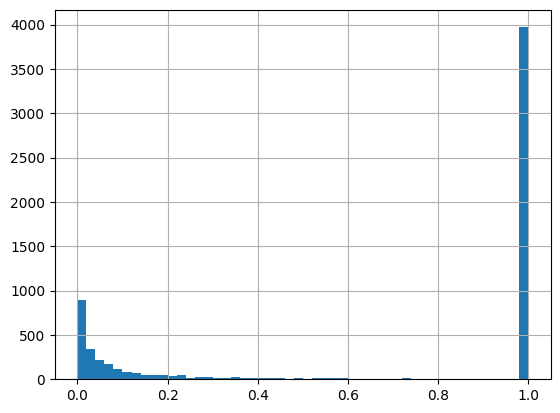

In [ ]:
progress.per.hist(bins = 50)

<Axes: >

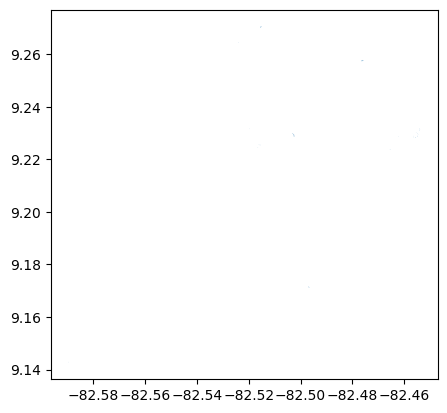

In [ ]:


node_id = "Nance de Riscó_4728"

nodes.loc[[node_id]].plot()

,id,count
0,Liberia_0,345.0
1,Tilarán_1,453.0
2,La Fortuna_2,158.0
3,Limón_3,596.0
4,Sixaola_4,880.0
...,...,...
6438,Bajo La Concepción_6440,300.0
6439,Alto de La Palma_6441,252.0
6440,Agua Viva_6442,399.0
6441,El Bongo_6443,287.0


In [ ]:
import numpy as np
import simulator.constants as con
import pandas as pd
from scipy.special import expit
import geopandas as gpd

In [ ]:
# Assigns id as index for quick search
nodes.index = nodes[con.ID]
edges.index = pd.MultiIndex.from_tuples(edges.apply(lambda row: (row[con.NODE_ID1], row[con.NODE_ID2]), axis = 1), names=[con.NODE_ID1, con.NODE_ID2])

# Geometries

# Inverse
edges_inv = edges.rename(columns={con.NODE_ID1 : con.NODE_ID2, con.NODE_ID2 : con.NODE_ID1}) 
edges_inv = edges_inv.swaplevel(con.NODE_ID1, con.NODE_ID2)
edges_inv.index.names = [con.NODE_ID1, con.NODE_ID2]
edges_inv = edges_inv[[con.NODE_ID1, con.NODE_ID2, con.VALUE, con.GEOMETRY]]

# Self Loops
self_edges = gpd.GeoDataFrame({con.NODE_ID1 : nodes[con.ID], con.NODE_ID2 : nodes[con.ID], con.VALUE : 1}, geometry = nodes[con.GEOMETRY])
self_edges.index = pd.MultiIndex.from_tuples(self_edges.apply(lambda row: (row[con.NODE_ID1], row[con.NODE_ID2]), axis = 1), names=[con.NODE_ID1, con.NODE_ID2])


geometries = pd.concat((edges, edges_inv, self_edges))
geometries = gpd.GeoDataFrame(geometries, geometry = "geometry")


In [ ]:

# Starts Simulation

disaster_on = False


# Initializes the forces
nodes[con.ATTRACTIVE_FORCE] = nodes[con.POPULATION].values / nodes[con.POPULATION].sum()
nodes[con.ATTRACTIVE_FORCE] = nodes[con.ATTRACTIVE_FORCE]  / nodes[con.ATTRACTIVE_FORCE].max()
nodes[con.REPELLING_FORCE] = 0

# Computes final force
nodes[con.FINAL_FORCE] = nodes[con.ATTRACTIVE_FORCE] - nodes[con.REPELLING_FORCE]

# Percentage of Population with coverage
population_with_coverage = 0.3

total_elements = int(np.round(population_with_coverage*population_network.nodes[con.POPULATION].sum()))


# Creates ID
device_trajectories = pd.DataFrame({con.ID : [i for i in range(total_elements)]})

# All devices start at node
device_trajectories[con.START_NODE] = np.random.choice(nodes[con.ID].values, total_elements,
              p=nodes[con.POPULATION].values / nodes[con.POPULATION].sum())

device_trajectories[con.END_NODE] = device_trajectories[con.START_NODE]




In [ ]:
# Extracts Neighbors
adjacent_nodes = {}

for node_id in nodes[con.ID]:
    
    # Creates the slice
    neighbors = set([node_id])

    # Node 1
    try:
        neighbors = neighbors.union(edges.loc[pd.IndexSlice[node_id, :], con.NODE_ID2].values)
    except KeyError:
        pass

    # Node 2
    try:
        neighbors = neighbors.union(edges.loc[pd.IndexSlice[:,node_id], con.NODE_ID1].values)
    except KeyError:
        pass

    adjacent_nodes[node_id] = list(neighbors)


In [ ]:
# Creates the node step
new_positions = []


def extract_destination_node(df):
    '''
    Extracts the next nodes for the current node
    '''

    node_id = df[con.START_NODE].iloc[0]

    forces = nodes.loc[adjacent_nodes[node_id],[con.FINAL_FORCE]]

    if disaster_on:
        forces[con.FINAL_FORCE] = forces[con.FINAL_FORCE].apply(expit)


    forces[con.FINAL_FORCE] /= forces[con.FINAL_FORCE].sum()

    new_positions = np.random.choice(forces.index.values, df.shape[0],
              p= forces[con.FINAL_FORCE].values)

    return pd.DataFrame({con.ID : df.index, con.START_NODE : node_id, con.END_NODE : new_positions}, index = df.index)
    

# Initializes movement (all devices are in nodes) 
device_trajectories = device_trajectories[[con.START_NODE]].groupby(con.START_NODE).apply(extract_destination_node).droplevel(0)


# Divides in two
node_trajectories = device_trajectories[device_trajectories[con.START_NODE] == device_trajectories[con.END_NODE]]
edge_trajectories = device_trajectories[device_trajectories[con.START_NODE] != device_trajectories[con.END_NODE]].copy()


# Process node trajectories
new_edge_trajectories = node_trajectories[[con.START_NODE]].groupby(con.START_NODE).apply(extract_destination_node).droplevel(0)




In [ ]:

if disaster_on:
    edge_trajectories[con.REACH_PROBABILITY] = nodes.loc[edge_trajectories[con.END_NODE], con.FINAL_FORCE].apply(expit).values
    edge_trajectories[con.REACH_PROBABILITY] /= ( edge_trajectories[con.REACH_PROBABILITY] + nodes.loc[edge_trajectories[con.START_NODE], con.FINAL_FORCE].apply(expit)).values
else:
    edge_trajectories[con.REACH_PROBABILITY] = nodes.loc[edge_trajectories[con.END_NODE], con.FINAL_FORCE].values
    edge_trajectories[con.REACH_PROBABILITY] /= edge_trajectories[con.REACH_PROBABILITY].values + nodes.loc[edge_trajectories[con.START_NODE], con.FINAL_FORCE].values

random_vector = np.random.random(edge_trajectories.shape[0])

# Devices that reach
edge_trajectories.loc[random_vector <= edge_trajectories[con.REACH_PROBABILITY], con.START_NODE] = edge_trajectories[con.END_NODE]

# Devices that don't
edge_trajectories.loc[random_vector > edge_trajectories[con.REACH_PROBABILITY], con.END_NODE] = edge_trajectories[con.START_NODE]

# Consolidates
new_node_trajectories = edge_trajectories[[con.ID, con.START_NODE, con.END_NODE]]

# Creates new frame
new_device_trajectories = pd.concat((new_node_trajectories, new_edge_trajectories))



In [ ]:
new_device_trajectories.shape[0]

3313841

In [ ]:
# Extracts Position
#indices = new_device_trajectories.apply(lambda row: (row[con.START_NODE], row[con.END_NODE]), axis = 1)

i = 0
for _, row in new_device_trajectories.iterrows():
    geometries.loc[[(row[con.START_NODE], row[con.END_NODE])]].sample_points(1)

    i+= 1

    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


KeyboardInterrupt: 

In [ ]:
new_edge_trajectories[new_edge_trajectories[con.START_NODE] == new_edge_trajectories[con.END_NODE]]

,id,start_node,end_node
424628,424628,"""U"" Centro - 4619","""U"" Centro - 4619"
1613181,1613181,"""U"" Centro - 4619","""U"" Centro - 4619"
1783237,1783237,"""U"" Centro - 4619","""U"" Centro - 4619"
57974,57974,20 de Abril - 5623,20 de Abril - 5623
445024,445024,20 de Abril - 5623,20 de Abril - 5623
...,...,...,...
265414,265414,Ánimas - 2793,Ánimas - 2793
302076,302076,Ánimas - 3133,Ánimas - 3133
404692,404692,Ánimas - 3133,Ánimas - 3133
2871612,2871612,Ánimas - 3133,Ánimas - 3133


In [ ]:
from os.path import join
import simulator.constants as con
import geopandas as gpd

world_pop_density_file = join(con.DATA_FOLDER,"costa_rica-panama/pd_2020_1km_ASCII_XYZ.csv")
populated_places_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_populated_places_points_shp")
road_lines_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_roads_lines_shp")
building_polygons_folder = join(con.DATA_FOLDER,"costa_rica-panama/hotosm_buildings_polygons_shp")

import numpy as np
import simulator.constants as con 
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import haversine_distances
from simulator.utils.geometric import haversine
from math import radians

from shapely.geometry import LineString, Point

import simulator.utils.geometric as geo_fun


,geometry,highway
0,"MULTILINESTRING ((-84.14531 9.95885, -84.14288...",service
1,"MULTILINESTRING ((-84.09124 9.94787, -84.09165...",secondary
2,"MULTILINESTRING ((-84.11712 9.94019, -84.11717...",trunk_link
3,"MULTILINESTRING ((-84.11645 9.93860, -84.11657...",trunk_link
4,"LINESTRING (-84.11648 9.93629, -84.11641 9.93624)",trunk_link
...,...,...
60168,"MULTILINESTRING ((-82.82806 8.87898, -82.82830...",unclassified
60169,"MULTILINESTRING ((-82.90541 8.83246, -82.90349...",unclassified
60170,"MULTILINESTRING ((-82.90799 8.44169, -82.90794...",footway
60171,"LINESTRING (-82.90817 8.44242, -82.90773 8.44224)",footway


In [ ]:

# Trims
new_geo = []

percentage_print = 0.1
print_every = int(np.floor(percentage_print*edges.shape[0]))

entire_geometry = roads.iloc[0][con.GEOMETRY]

print("Trimming Roads") # Apply generates out of memory
for i, edge_row in edges.iterrows():

    # Trims
    new_geo.append(geo_fun.trim_road(entire_geometry, edge_row.lon_x, edge_row.lat_x, edge_row.lon_y, edge_row.lat_y))

    print(i)
    if i % print_every == 0:
        print(f"   Progress: {np.round(100*i/edges.shape[0])}%")

print("Done trimming")

In [ ]:
nodes = nodes.reset_index(drop = True)